In [48]:
!pip install transformers


In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from keras.layers import LSTM, Dense, Bidirectional, Embedding, Flatten, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report
from transformers import DistilBertTokenizerFast

In [28]:
df_sarcasm = pd.read_csv('NLPMiniProject_data.csv')
df_sarcasm.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


In [29]:
df_sarcasm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              15000 non-null  object
 1   comment         15000 non-null  object
 2   date            15000 non-null  object
 3   down            15000 non-null  int64 
 4   parent_comment  15000 non-null  object
 5   score           15000 non-null  int64 
 6   top             15000 non-null  int64 
 7   topic           15000 non-null  object
 8   user            15000 non-null  object
 9   label           15000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 1.1+ MB


In [30]:
df_sarcasm.shape

(15000, 10)

In [51]:
X = df_sarcasm['comment']
y = df_sarcasm['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=10)
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
print('Vocab length :',len(tokenizer.word_index)+1)

Vocab length : 16188


In [52]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(len, sequences)))
    
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [53]:
X_train = get_sequences(X_train,tokenizer,train=True)
X_test = get_sequences(X_test,tokenizer,train=False,max_seq_length=X_train.shape[1])

In [54]:
X_train

array([[  90,   70,  351, ...,    0,    0,    0],
       [  36, 1287,   31, ...,    0,    0,    0],
       [ 134,   73,  324, ...,    0,    0,    0],
       ...,
       [  36,   30,   62, ...,    0,    0,    0],
       [  30,   25,    3, ...,    0,    0,    0],
       [   6, 1148,   63, ...,    0,    0,    0]])

In [55]:
X_train.shape

(12750, 134)

In [56]:
print("Sequence length:", X_train.shape[1])

Sequence length: 134


In [57]:
y_train.value_counts()

1    6380
0    6370
Name: label, dtype: int64

In [58]:
inputs = tf.keras.Input(shape=(134,))
x = tf.keras.layers.Embedding(input_dim=16188,output_dim=64)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

In [59]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 134)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 134, 64)           1036032   
                                                                 
 flatten_1 (Flatten)         (None, 8576)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1097856   
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,150,529
Trainable params: 2,150,529
Non-tra

In [60]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(X_train,y_train,batch_size=32,epochs=5,validation_split=0.2,callbacks=callback)

Epoch 1/5
319/319 [==============================] - 6s 17ms/step - loss: 0.6697 - accuracy: 0.5806 - auc: 0.6137 - val_loss: 0.6161 - val_accuracy: 0.6592 - val_auc: 0.7135
Epoch 2/5
319/319 [==============================] - 5s 16ms/step - loss: 0.4432 - accuracy: 0.7933 - auc: 0.8756 - val_loss: 0.7265 - val_accuracy: 0.6318 - val_auc: 0.6832
Epoch 3/5
319/319 [==============================] - 5s 16ms/step - loss: 0.1247 - accuracy: 0.9556 - auc: 0.9902 - val_loss: 1.0949 - val_accuracy: 0.6184 - val_auc: 0.6577
Epoch 4/5
319/319 [==============================] - 5s 16ms/step - loss: 0.0479 - accuracy: 0.9825 - auc: 0.9985 - val_loss: 1.4268 - val_accuracy: 0.6039 - val_auc: 0.6422


In [61]:
results = model.evaluate(X_test,y_test,verbose=0)
print("Accuracy: {:.2f}%".format(results[1] * 100))
print("     AUC: {:.5f}".format(results[2]))

Accuracy: 64.80%
     AUC: 0.70970


In [62]:
y_pred = np.squeeze(model.predict(X_test) >= 0.5).astype(np.int)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
clr = classification_report(y_test, y_pred, labels=[0, 1], target_names=["No Sarcasm", "Sarcasm"])

<ipython-input-62-8ec60c42573e>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze(model.predict(X_test) >= 0.5).astype(np.int)


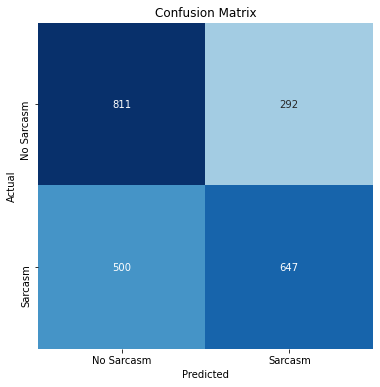

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Sarcasm       0.62      0.74      0.67      1103
     Sarcasm       0.69      0.56      0.62      1147

    accuracy                           0.65      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.65      0.65      0.65      2250



In [63]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [64]:
# https://www.kaggle.com/code/gcdatkin/news-headline-sarcasm-detection

In [65]:

#